# TUTORIAL FOR THE P3D EMULATOR (FORESTFLOW)

In [4]:
import sys
import os
import matplotlib.pyplot as plt

In [2]:
from ForestFlow.archive import GadgetArchive3D
from ForestFlow.plots_v0 import plot_test_p3d
from ForestFlow.P3D_cINN import P3DEmulator

In [5]:
def ls_level(folder, nlevels):
    for ii in range(nlevels):
        folder = os.path.dirname(folder)
    folder += "/"
    return folder

path_program = ls_level(os.getcwd(), 1)
print(path_program)
sys.path.append(path_program)

/global/u1/l/lcabayol/P3D/ForestFlow/


## LOAD P3D ARCHIVE

In [6]:
%%time
folder_lya_data = path_program +  "/data/best_arinyo/"

Archive3D = GadgetArchive3D(
    base_folder=path_program[:-1], 
    folder_data=folder_lya_data, 
    force_recompute_plin=True,
    average='both'
)
print(len(Archive3D.training_data))


1650
CPU times: user 56 s, sys: 2.56 s, total: 58.6 s
Wall time: 1min 3s


## TRAIN EMULATOR

In [7]:
p3d_emu = P3DEmulator(
    Archive3D.training_data,
    Archive3D.emu_params,
    nepochs=300,
    lr=0.001,#0.005
    batch_size=20,
    step_size=200,
    gamma=0.1,
    weight_decay=0,
    adamw=True,
    nLayers_inn=12,#15
    Archive=Archive3D,
    use_chains=False,
    chain_samp=100_000,
    grad_clip_threshold = 1e25,
    input_space='Arinyo',
    folder_chains='/data/desi/scratch/jchavesm/p3d_fits_new/'
)

Emualtor optimized in 294.2243573665619 seconds


## TEST EMULATOR

fit {'bias': -0.2265946739714242, 'beta': 1.2248241556400337, 'q1': 0.5508070368332233, 'kvav': 0.7735041489709146, 'av': 0.5316646888234277, 'bv': 1.841648720663841, 'kp': 13.45975658765607, 'q2': 0.1882466279205535}
emu {'bias': 0.22997299581766129, 'beta': 1.2144232988357544, 'q1': 0.4625944048166275, 'kvav': 0.721228837966919, 'av': 0.4942365884780884, 'bv': 1.8016122579574585, 'kp': 13.27148723602295, 'q2': 0.27393123507499695}


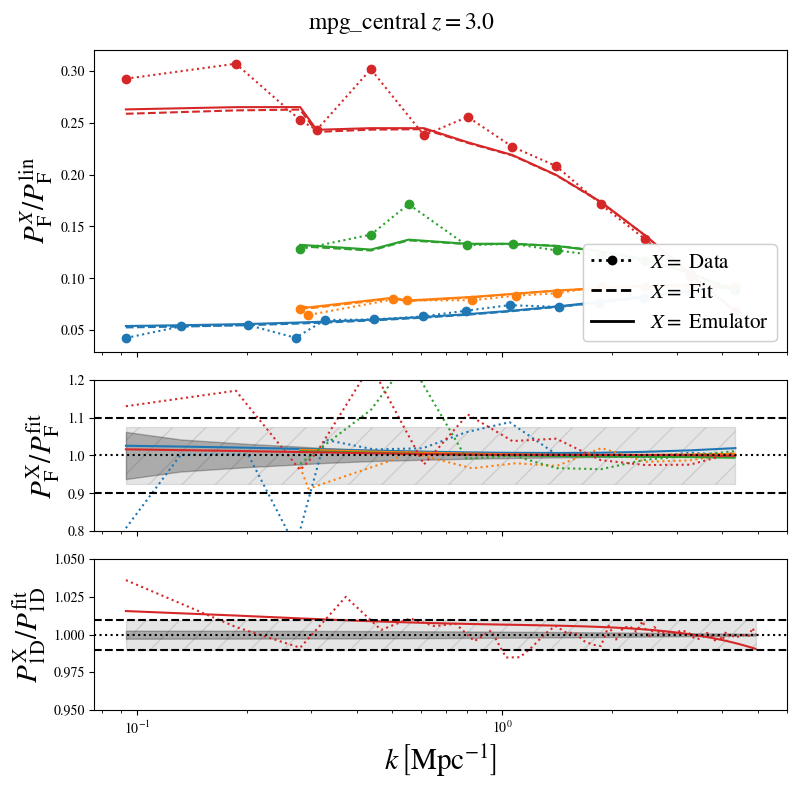

In [8]:
sim_label = "mpg_central"
ind_book = 6
plot_test_p3d(ind_book, Archive3D, p3d_emu, sim_label)